# Water Quality Parameters Maps (CHL, TSM) - Coregistration¶

In [1]:
# Styling notebook

# System
import os
import sys

# Import scripts libraries for the project
sys.path.append('./src/python')

# Import the function to update the notebook style
from nbConfig import (css_styling)

css_styling()

## 0. Import libraries

Import the required libraries and setup the current working directories.

In [2]:
# Data
import numpy as np
import pandas as pd

# Spatial Data
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import richdem as rd

# Data visualization
import matplotlib.pyplot as plt
from rasterio.plot import show_hist

# Import custom libraries
import wqpFunctions as wqp

In [3]:
# Current Working Directories
cwd = {
    'local': '.',
    'in': './in/data/wqp/S3',
    'out': './out/Coregistration',
    'vector': './vector',
}

In [4]:
os.path.join(cwd['in'],'simile_laghi_extent/simile_laghi_extent_600m_buff.shp')

'./in/data/wqp/S3\\simile_laghi_extent/simile_laghi_extent_600m_buff.shp'

Text(0.5, 1.0, 'Lakes shape and mask for data processing')

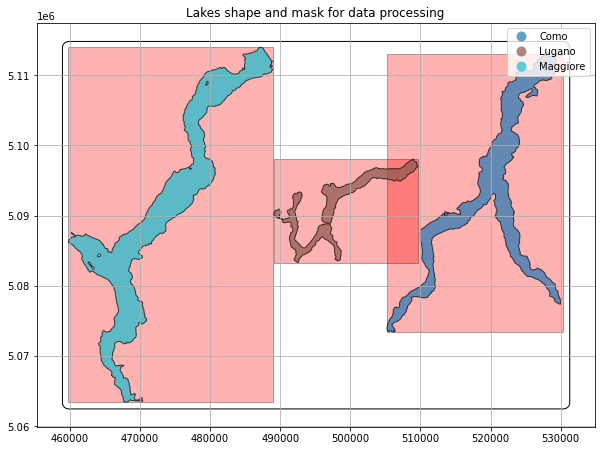

In [5]:
# Lakes shapes and mask
featureLakes = os.path.join(cwd['vector'],'simile_laghi/simile_laghi.shp')
featureGeometry = os.path.join(cwd['vector'],'simile_laghi_extent/simile_laghi_extent_600m_buff.shp')
featureBoxes = os.path.join(cwd['vector'],'simile_laghi_bboxes/simile_laghi_bboxes.shp')
# DataFrame of the lakes and mask
gdf_maskWQP = gpd.read_file(featureGeometry)
gdf_lakesWQP = gpd.read_file(featureLakes)
gdf_bboxesWQP = gpd.read_file(featureBoxes)
# Visualization of the lakes and mask
fig, ax = plt.subplots(figsize=(10, 10))
gdf_maskWQP.plot(ax = ax, color='white',edgecolor='k', alpha=1)
gdf_bboxesWQP.plot(ax = ax, color='red',edgecolor='k', alpha=0.3)
gdf_lakesWQP.plot(column='Nome', ax = ax ,edgecolor='k', alpha=0.7, legend=True)
ax.grid()
ax.set_title('Lakes shape and mask for data processing')

In [6]:
# # Paths for the outputs of the master band

# Input Master Reference Band
master_name = 'S3A_IT_20190315T094218_L1'
oa_bands_master = os.path.join(cwd['in'], 'oa', master_name+'.tif')

# Output Master Reference Band - Masked to the extent of the lakes
out_path_master = os.path.join(cwd['out'], 'master', 'oa_18/full')

# Output Master Slope Reference Band
out_path_master_slope = os.path.join(cwd['out'], 'master', 'slope_oa_18/full')

In [7]:
# Master Band - Read Dataset and Crop by Features
master = wqp.wqp(oa_bands_master)
master.readWQP()
# Save Master Band
ref_band = 18
master.cropRasterByFeatures(featureGeometry,'Nome')
master.saveMaskedImage(os.path.join(out_path_master,master.name+'_Oa_18.tif'),'wqp',band=ref_band)

Text(0.5, 1.0, 'Master Band for Coregistraton - S3A_IT_20190315T094218_L1')

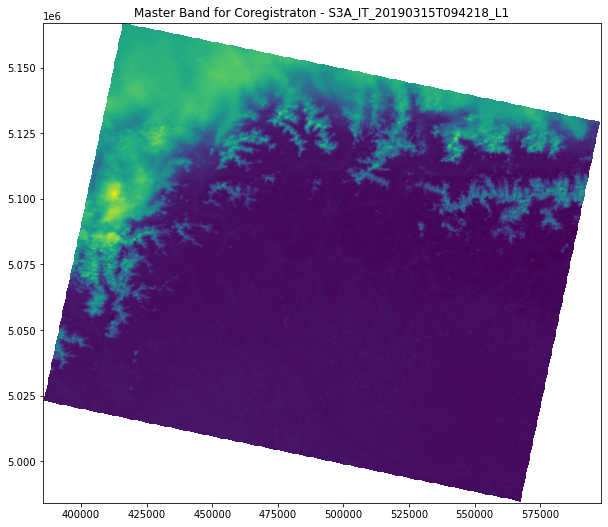

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax = rasterio.plot.show((master.image, 1), ax=ax, cmap='viridis')
ax.set_title('Master Band for Coregistraton - {}'.format(master_name))

In [9]:
os.path.join(out_path_master_slope,master.name+'_Oa_18.tif')

'./out/Coregistration\\master\\slope_oa_18/full\\S3A_IT_20190315T094218_L1_Oa_18.tif'

In [10]:
# Read Master Band - Compute and Save Slope Estimates
rd_master = rd.LoadGDAL(os.path.join(out_path_master,master.name+'_Oa_18.tif'), no_data=0)
slope_master = rd.TerrainAttribute(rd_master, attrib='slope_riserun')
slope_master
rd.SaveGDAL(os.path.join(out_path_master_slope,master.name+'_Oa_18.tif'), slope_master)

In [11]:
# Read Reference Band Slope - Crop the slope estimates in the different lakes
slope_master = wqp.wqp(os.path.join(out_path_master_slope,master_name+'_Oa_18.tif'))
slope_master.readWQP()
slope_master.cropRasterByFeatures(featureLakes, 'Nome')
for nameFeature in list(gdf_bboxesWQP.Nome):
    out_path = os.path.join(cwd['out'],'master','slope_oa_18\\partial','{}\\{}'.format(nameFeature,master_name+'_Oa_18.tif'))
    slope_master.saveMaskedImage(out_path,nameFeature, band=1)

## 1. Coregistration

### 1.1. Images subsets - Radiance Reference Band - Slope

Master Image

In [ ]:
# Define the reference (master) raster for the corregistration algorithm
oa_bands_master =  os.path.join(cwd['in'],'oa','S3A_IT_20190315T094218_L1.tif')
master = wqp.wqp(oa_bands_master)
master.readWQP()
# Mask layer for creating he subsets
featureGeometry = './vector/simile_laghi_extent/simile_laghi_extent_600m_buff.shp'
# Cropped master raster
master.cropRasterByFeatures(featureGeometry,'Nome')
# Export masked master dataset
out_path_master = os.path.join(cwd['out'],'master/oa_18')
master.saveMaskedImage(os.path.join(out_path_master,'full',master.name+'_Oa_18.tif'),'wqp',band=18)
# Generate the slope layer for the master dataset
out_path_master_slope = os.path.join(cwd['out'],'master/slope_oa_18')
rd_master = rd.LoadGDAL(os.path.join(out_path_master_slope,'full',master.name+'_Oa_18.tif'), no_data=0)
slope_master = rd.TerrainAttribute(rd_master, attrib='slope_riserun')
# Save the computed slope dataset
rd.SaveGDAL(os.path.join(out_path_master_slope,'full',master.name+'_Oa_18.tif'), slope_master)

Slave images

In [31]:
os.listdir(os.path.join(cwd['out'],'slave/slope_oa_18/full'))

['S3A_IT_20190101T093449_L1_Oa_18.tif',
 'S3A_IT_20190102T090838_L1_Oa_18.tif',
 'S3A_IT_20190107T101943_L1_Oa_18.tif',
 'S3A_IT_20190108T095332_L1_Oa_18.tif',
 'S3A_IT_20190109T092721_L1_Oa_18.tif',
 'S3A_IT_20190112T094948_L1_Oa_18.tif',
 'S3A_IT_20190113T092337_L1_Oa_18.tif',
 'S3A_IT_20190115T101215_L1_Oa_18.tif',
 'S3A_IT_20190116T094604_L1_Oa_18.tif',
 'S3A_IT_20190117T091953_L1_Oa_18.tif',
 'S3A_IT_20190119T100831_L1_Oa_18.tif',
 'S3A_IT_20190120T094220_L1_Oa_18.tif',
 'S3A_IT_20190121T091609_L1_Oa_18.tif',
 'S3A_IT_20190123T100447_L1_Oa_18.tif',
 'S3A_IT_20190124T093836_L1_Oa_18.tif',
 'S3A_IT_20190125T091225_L1_Oa_18.tif',
 'S3A_IT_20190127T100103_L1_Oa_18.tif',
 'S3A_IT_20190128T093452_L1_Oa_18.tif',
 'S3A_IT_20190129T090841_L1_Oa_18.tif',
 'S3A_IT_20190201T093108_L1_Oa_18.tif',
 'S3A_IT_20190203T101945_L1_Oa_18.tif',
 'S3A_IT_20190204T095334_L1_Oa_18.tif',
 'S3A_IT_20190205T092723_L1_Oa_18.tif',
 'S3A_IT_20190208T094950_L1_Oa_18.tif',
 'S3A_IT_20190209T092339_L1_Oa_18.tif',


In [35]:
for root, dirs, files in os.walk(os.path.join('in','data/wqp/s3/oa')):
    for f in files:
        if ((f.endswith('.tif')) & (f.split('.')[0]+'_Oa_18.tif' not in os.listdir(os.path.join(cwd['out'],'slave/slope_oa_18/full')))):
            print(f.split('_')[0]+'_Oa_18.tif')

S3B_Oa_18.tif
S3B_Oa_18.tif
S3B_Oa_18.tif
S3B_Oa_18.tif
S3B_Oa_18.tif
S3B_Oa_18.tif
S3B_Oa_18.tif


In [36]:
#TODO: estimate only for the missing datasets in the folder

# Output folder for the slave image
out_path_slave = os.path.join(cwd['out'],'slave/oa_18')
out_path_slave_slope = os.path.join(cwd['out'],'slave/slope_oa_18')
# Apply the mask to the coregistered (slave) images
for root, dirs, files in os.walk(os.path.join('in','data/wqp/s3/oa')):
    for f in files:
        if ((f.endswith('.tif')) & (f.split('.')[0]+'_Oa_18.tif' not in os.listdir(os.path.join(cwd['out'],'slave/slope_oa_18/full')))):
            oa_bands_slave = os.path.join(root,f)
            slave = wqp.wqp(oa_bands_slave)
            slave.readWQP()
            slave.cropRasterByFeatures(featureGeometry,'Nome')
            slave.saveMaskedImage(os.path.join(out_path_slave,'full',slave.name+'_Oa_18.tif'),'wqp',band=18)
            rd_slave = rd.LoadGDAL(os.path.join(out_path_slave,'full',slave.name+'_Oa_18.tif'), no_data=0)
            slope_slave = rd.TerrainAttribute(rd_slave, attrib='slope_riserun')
            rd.SaveGDAL(os.path.join(out_path_slave_slope,'full',slave.name+'_Oa_18.tif'), slope_slave)
            try:
                for nameFeature in list(gdf_bboxesWQP.Nome):
                    slope_slave = wqp.wqp(os.path.join(out_path_slave_slope,'full',slave.name+'_Oa_18.tif'))
                    print(os.path.join(out_path_slave_slope,'full',slave.name+'_Oa_18.tif'))
                    slope_slave.cropRasterByFeatures(featureLakes, 'Nome')
                    out_path = os.path.join(out_path_slave_slope,'partial',nameFeature,slave.name+'_Oa_18.tif')
                    slope_slave.saveMaskedImage(out_path,nameFeature, band=1)
            except:
                print('hello')

S3A_IT_20190101T093449_L1.tif
S3A_IT_20190102T090838_L1.tif
S3A_IT_20190107T101943_L1.tif
S3A_IT_20190108T095332_L1.tif
S3A_IT_20190109T092721_L1.tif
S3A_IT_20190112T094948_L1.tif
S3A_IT_20190113T092337_L1.tif
S3A_IT_20190115T101215_L1.tif
S3A_IT_20190116T094604_L1.tif
S3A_IT_20190117T091953_L1.tif
S3A_IT_20190119T100831_L1.tif
S3A_IT_20190120T094220_L1.tif
S3A_IT_20190121T091609_L1.tif
S3A_IT_20190123T100447_L1.tif
S3A_IT_20190124T093836_L1.tif
S3A_IT_20190125T091225_L1.tif
S3A_IT_20190127T100103_L1.tif
S3A_IT_20190128T093452_L1.tif
S3A_IT_20190129T090841_L1.tif
S3A_IT_20190201T093108_L1.tif
S3A_IT_20190203T101945_L1.tif
S3A_IT_20190204T095334_L1.tif
S3A_IT_20190205T092723_L1.tif
S3A_IT_20190208T094950_L1.tif
S3A_IT_20190209T092339_L1.tif
S3A_IT_20190211T101216_L1.tif
S3A_IT_20190212T094605_L1.tif
S3A_IT_20190213T091954_L1.tif
S3A_IT_20190215T100832_L1.tif
S3A_IT_20190216T094221_L1.tif
S3A_IT_20190217T091610_L1.tif
S3A_IT_20190219T100447_L1.tif
S3A_IT_20190220T093836_L1.tif
S3A_IT_201

S3A_IT_20200720T100111_L1.tif
S3A_IT_20200721T093500_L1.tif
S3A_IT_20200722T090849_L1.tif
S3A_IT_20200724T095727_L1.tif
S3A_IT_20200725T093116_L1.tif
S3A_IT_20200727T101953_L1.tif
S3A_IT_20200728T095342_L1.tif
S3A_IT_20200729T092731_L1.tif
S3A_IT_20200801T094957_L1.tif
S3A_IT_20200802T092346_L1.tif
S3A_IT_20200804T101223_L1.tif
S3A_IT_20200805T094612_L1.tif
S3A_IT_20200806T092001_L1.tif
S3A_IT_20200808T100839_L1.tif
S3A_IT_20200809T094228_L1.tif
S3A_IT_20200810T091617_L1.tif
S3A_IT_20200812T100454_L1.tif
S3A_IT_20200813T093843_L1.tif
S3A_IT_20200814T091232_L1.tif
S3A_IT_20200816T100109_L1.tif
S3A_IT_20200817T093458_L1.tif
S3A_IT_20200818T090847_L1.tif
S3A_IT_20200820T095724_L1.tif
S3A_IT_20200821T093113_L1.tif
S3A_IT_20200823T101950_L1.tif
S3A_IT_20200824T095339_L1.tif
S3A_IT_20200825T092728_L1.tif
S3A_IT_20200828T094954_L1.tif
S3A_IT_20200829T092343_L1.tif
S3A_IT_20200831T101220_L1.tif
S3A_IT_20200901T094609_L1.tif
S3A_IT_20200902T091958_L1.tif
S3A_IT_20200904T100835_L1.tif
S3A_IT_202

S3A_IT_20220208T093507_L1.tif
S3A_IT_20220209T090856_L1.tif
S3A_IT_20220211T095733_L1.tif
S3A_IT_20220212T093122_L1.tif
S3A_IT_20220214T101959_L1.tif
S3A_IT_20220215T095348_L1.tif
S3A_IT_20220216T092737_L1.tif
S3A_IT_20220219T095003_L1.tif
S3A_IT_20220220T092352_L1.tif
S3A_IT_20220222T101229_L1.tif
S3A_IT_20220223T094617_L1.tif
S3A_IT_20220224T092007_L1.tif
S3A_IT_20220226T100844_L1.tif
S3A_IT_20220227T094233_L1.tif
S3A_IT_20220228T091622_L1.tif
S3A_IT_20220302T100459_L1.tif
S3A_IT_20220303T093848_L1.tif
S3A_IT_20220304T091238_L1.tif
S3A_IT_20220306T100115_L1.tif
S3A_IT_20220307T093504_L1.tif
S3A_IT_20220308T090853_L1.tif
S3A_IT_20220310T095730_L1.tif
S3A_IT_20220311T093119_L1.tif
S3A_IT_20220313T101956_L1.tif
S3A_IT_20220314T095345_L1.tif
S3A_IT_20220315T092734_L1.tif
S3A_IT_20220318T095002_L1.tif
S3A_IT_20220319T092351_L1.tif
S3A_IT_20220321T101229_L1.tif
S3A_IT_20220322T094618_L1.tif
S3A_IT_20220323T092007_L1.tif
S3A_IT_20220325T100845_L1.tif
S3A_IT_20220326T094234_L1.tif
S3A_IT_202

S3B_IT_20210108T100254_L1.tif
S3B_IT_20210109T093643_L1.tif
S3B_IT_20210110T091032_L1.tif
S3B_IT_20210112T095909_L1.tif
S3B_IT_20210113T093258_L1.tif
S3B_IT_20210115T102135_L1.tif
S3B_IT_20210116T095524_L1.tif
S3B_IT_20210117T092913_L1.tif
S3B_IT_20210120T095139_L1.tif
S3B_IT_20210121T092528_L1.tif
S3B_IT_20210123T101405_L1.tif
S3B_IT_20210124T094753_L1.tif
S3B_IT_20210125T092142_L1.tif
S3B_IT_20210127T101019_L1.tif
S3B_IT_20210128T094408_L1.tif
S3B_IT_20210129T091757_L1.tif
S3B_IT_20210131T100634_L1.tif
S3B_IT_20210201T094023_L1.tif
S3B_IT_20210202T091411_L1.tif
S3B_IT_20210204T100249_L1.tif
S3B_IT_20210205T093638_L1.tif
S3B_IT_20210206T091027_L1.tif
S3B_IT_20210208T095905_L1.tif
S3B_IT_20210209T093254_L1.tif
S3B_IT_20210211T102132_L1.tif
S3B_IT_20210212T095521_L1.tif
S3B_IT_20210213T092911_L1.tif
S3B_IT_20210216T095138_L1.tif
S3B_IT_20210217T092527_L1.tif
S3B_IT_20210219T101405_L1.tif
S3B_IT_20210220T094754_L1.tif
S3B_IT_20210221T092143_L1.tif
S3B_IT_20210223T101021_L1.tif
S3B_IT_202

S3B_IT_20220727T091136_L1.tif
S3B_IT_20220729T100013_L1.tif
S3B_IT_20220730T093402_L1.tif
S3B_IT_20220731T090751_L1.tif
S3B_IT_20220802T095628_L1.tif
S3B_IT_20220803T093017_L1.tif
S3B_IT_20220805T101854_L1.tif
S3B_IT_20220806T095243_L1.tif
S3B_IT_20220807T092632_L1.tif
S3B_IT_20220809T101809_L1.tif
S3B_IT_20220810T095159_L1.tif
S3B_IT_20220811T092548_L1.tif
S3B_IT_20220813T101426_L1.tif
S3B_IT_20220814T094815_L1.tif
S3B_IT_20220815T092204_L1.tif
S3B_IT_20220817T101042_L1.tif
S3B_IT_20220818T094431_L1.tif
S3B_IT_20220819T091820_L1.tif
S3B_IT_20220821T100658_L1.tif
S3B_IT_20220822T094047_L1.tif
./out/Coregistration\slave/slope_oa_18\full\S3B_IT_20220822T094047_L1_Oa_18.tif
./out/Coregistration\slave/slope_oa_18\full\S3B_IT_20220822T094047_L1_Oa_18.tif
./out/Coregistration\slave/slope_oa_18\full\S3B_IT_20220822T094047_L1_Oa_18.tif
S3B_IT_20220823T091436_L1.tif
./out/Coregistration\slave/slope_oa_18\full\S3B_IT_20220823T091436_L1_Oa_18.tif
./out/Coregistration\slave/slope_oa_18\full\S3B_IT

### 1.3. Subset WQP - sample maps

In [143]:
# Output folder for the slave image
in_path = './in/data/wqp/L8/wqp_high_clouds/lswt'
out_path = os.path.join('./in/data\wqp/L8/wqp_high_clouds/lswt/cropped')
sensor = 'S3'
shared_maps = list(set(os.listdir(in_path)).intersection(os.listdir(out_path)))
missing_maps = list(set(os.listdir(in_path)) ^ set(os.listdir(out_path)))
print((missing_maps))
# Apply the mask to the coregistered (slave) images
for root, dirs, files in os.walk(in_path):
    for f in missing_maps:
        if ((f.endswith('.tif')) & (dirs == ['cropped'])):
            try:
                chl_map = os.path.join(in_path,f)
                wqp_map = wqp.wqp(chl_map)
                wqp_map.readWQP()
                wqp_map.cropRasterByFeatures(featureGeometry,'Nome')
                wqp_map.saveMaskedImage(os.path.join(out_path,f),'wqp',band=1)
                wqp_map.image.close()
            except:
                # Open a file with access mode 'a'
                file_object = open(os.path.join('./in/data\wqp/L8/wqp_high_clouds/lswt/cropped',f'error_images_{sensor}.txt'), 'a')
                # Append 'hello' at the end of file
                file_object.write(wqp_map.name)
                file_object.write("\n")
                # Close the file
                file_object.close()

['L8_LSWT_IT_20220206_L1.tif', 'L8_LSWT_IT_20220513_L1.tif', 'L8_LSWT_IT_20220427_L1.tif', 'L8_LSWT_IT_20220819_L1.tif', 'L8_LSWT_IT_20220904_L1.tif', 'L8_LSWT_IT_20220310_L1.tif', 'L8_LSWT_IT_20220817_L1.tif', 'L8_LSWT_IT_20220121_L1.tif', 'L8_LSWT_IT_20220529_L1.tif', 'L8_LSWT_IT_20220326_L1.tif', 'L8_LSWT_IT_20220105_L1.tif', 'L8_LSWT_IT_20220522_L1.tif', 'L8_LSWT_IT_20220810_L1.tif', 'L8_LSWT_IT_20220911_L1.tif', 'L8_LSWT_IT_20220222_L1.tif', 'cropped']


In [125]:
a = os.listdir('./in/data/wqp/S3/wqp_no_clip/tsm')[-1]
print(a.split('_')[3])
any(a.split('_')[3] in s for s in os.listdir('./out/Coregistration/wqp/S3/full/tsm'))

20220906T095159


False

In [140]:
# Output folder for the slave image
out_path_crop = os.path.join('./out/Coregistration/wqp/S3/partial/tsm')
# Apply the mask to the coregistered (slave) images
for root, dirs, files in os.walk('./in/data/wqp/S3/wqp_no_clip/tsm'):
    for f in files[0:10]:
        if ((f.endswith('.tif')) & (any(a.split('_')[3] in s for s in os.listdir('./out/Coregistration/wqp/S3/full/tsm'))==True)):
            chl_map = os.path.join(root,f)
            wqp_map = wqp.wqp(chl_map)
            wqp_map.readWQP()
            wqp_map.cropRasterByFeatures(featureBoxes,'Nome')
            for nameFeature in list(gdf_bboxesWQP.Nome):
                try:
                    wqp_map.saveMaskedImage(os.path.join(out_path_crop,nameFeature,wqp_map.name+'.tif'),nameFeature,band=1)

                except:
                    print(f,':',nameFeature)

Lake Maggiore does not overlay the raster layer
Lake Lugano does not overlay the raster layer
S3A_TSM_IT_20190102T090838_L1.tif : Maggiore
S3A_TSM_IT_20190102T090838_L1.tif : Lugano
Lake Maggiore does not overlay the raster layer
Lake Lugano does not overlay the raster layer
S3A_TSM_IT_20190102T090838_L1.tif : Maggiore
S3A_TSM_IT_20190102T090838_L1.tif : Lugano


In [33]:
featureGeometry

'./vector\\simile_laghi_extent/simile_laghi_extent_600m_buff.shp'

### 1.4. Image coregistration

Data Visualization and Analysis

In [114]:
import numpy as np
from skimage.io import imread
import pylab as pl

Flow computation

In [115]:
sys.path.append('./src/python/gefolki/python')
from algorithm import EFolki
from tools import wrapData

In [116]:
# Master dataset
in_path_master = os.path.join(out_path_master_slope,'S3A_IT_20190315T094218_L1_Oa_18.tif')
master_im = imread(in_path_master)
master_im = master_im[:master_im.shape[0]-1,:master_im.shape[1]-1]
master_im = master_im.astype(np.float32)
master_im = np.nan_to_num(master_im, copy=True, nan=0.0, posinf=None, neginf=None)

In [117]:
def saveMaskedImage(out_path,in_file,data,transf):
    with rasterio.open(in_file) as src:
        profile = src.profile.copy()
        profile.update({
                'dtype': 'float32',
                'height': data.shape[0],
                'width': data.shape[1],
                'transform': transf
         })  

    with rasterio.open(out_path, 'w', **profile) as dst:
        data[data<=0] = np.nan
        dst.write_band(1, data)

In [130]:
any('abc' in s for s in os.listdir('./out/Coregistration/wqp/S3/full/tsm'))

False

In [133]:
for root, dirs, files in os.walk('./out/Coregistration/slave/slope_oa_18/full'):
    for f in files:
        if (f.endswith('.tif') and (any(f.split('_')[2] in s for s in os.listdir('./out/Coregistration/wqp/S3/full/tsm')))==False):
            print(f)

S3A_IT_20190102T090838_L1_Oa_18.tif
S3A_IT_20190129T090841_L1_Oa_18.tif
S3A_IT_20190225T090841_L1_Oa_18.tif
S3A_IT_20190324T090841_L1_Oa_18.tif
S3A_IT_20190420T090846_L1_Oa_18.tif
S3A_IT_20190517T090847_L1_Oa_18.tif
S3A_IT_20190613T090846_L1_Oa_18.tif
S3A_IT_20190710T090846_L1_Oa_18.tif
S3A_IT_20190806T090844_L1_Oa_18.tif
S3A_IT_20190902T090841_L1_Oa_18.tif
S3A_IT_20190929T090844_L1_Oa_18.tif
S3A_IT_20191026T090845_L1_Oa_18.tif
S3A_IT_20191122T090842_L1_Oa_18.tif
S3A_IT_20191219T090840_L1_Oa_18.tif
S3A_IT_20200115T090843_L1_Oa_18.tif
S3A_IT_20200211T090843_L1_Oa_18.tif
S3A_IT_20200309T090842_L1_Oa_18.tif
S3A_IT_20200405T090847_L1_Oa_18.tif
S3A_IT_20200502T090850_L1_Oa_18.tif
S3A_IT_20200529T090850_L1_Oa_18.tif
S3A_IT_20200625T090849_L1_Oa_18.tif
S3A_IT_20200722T090849_L1_Oa_18.tif
S3A_IT_20200818T090847_L1_Oa_18.tif
S3A_IT_20200914T090846_L1_Oa_18.tif
S3A_IT_20201011T090848_L1_Oa_18.tif
S3A_IT_20201107T090847_L1_Oa_18.tif
S3A_IT_20201204T090842_L1_Oa_18.tif
S3A_IT_20210127T090850_L1_Oa

In [137]:
#TODO: coregister only the missing datasets to be coregistered

from rasterio.merge import merge

in_path_master = './out/Coregistration/master/slope_oa_18/partial'
in_path_slave = './out/Coregistration/slave/slope_oa_18/partial'
in_path_wqp = './out/Coregistration/wqp/S3/partial/tsm'
out_path_wqp = './out/Coregistration/wqp/S3/partial_coregistered/tsm'
typology = 'TSM'
# Image coregistration
for root, dirs, files in os.walk('./out/Coregistration/slave/slope_oa_18/full'):
    for f in files[0:10]:
        if (f.endswith('.tif') and (any(f.split('_')[2] in s for s in os.listdir('./out/Coregistration/wqp/S3/full/tsm')))==True):
            print(f)
            raster_collection = dict()
            for nameFeature in list(gdf_bboxesWQP.Nome):
                try:
                    # Determine the paths to the partial rasters (crop per lake)
                    master_path = os.path.join(in_path_master,nameFeature,master.name+'_Oa_18.tif')
                    slave_path = os.path.join(in_path_slave,nameFeature,f)
                    s_n = f.split('_')[:-2]
                    s_n.insert(1,typology)
                    slave_name_wqp = '_'.join(s_n)+'.tif'
                    wqp_path = os.path.join(in_path_wqp,nameFeature,slave_name_wqp)
                    # Read the images
                    master_im = imread(master_path)
                    slave_im = imread(slave_path)
                    wqp_map = imread(wqp_path)

                    # Read shape of the maser raster (fix width and height of the rasters for the coregistered images following the reference band)
                    master_width = master_im.shape[0]
                    master_height = master_im.shape[1]
                    # Remove the nan values (GeFolki processing requirement)
                    master_im = master_im.astype(np.float32)
                    slave_im = slave_im.astype(np.float32)
                    wqp_map = wqp_map.astype(np.float32)
                    master_im = np.nan_to_num(master_im[:master_width-1,:master_height-1], copy=True, nan=0.0, posinf=None, neginf=None)
                    slave_im = np.nan_to_num(slave_im[:master_width-1,:master_height-1], copy=True, nan=0.0, posinf=None, neginf=None)

                    # Flow computation
                    u, v = EFolki(master_im, slave_im, iteration=4, radius=[32,28,20,16,8], rank=4, levels=2)

                    # Resampling and final result
                    WQPrecalee = wrapData(wqp_map[:master_width-1,:master_height-1], u, v)
                    # Export partial datasets
                    # Import the sample dataset master - Reference coregistration band
                    src_master = wqp.wqp(master_path)
                    src_master.readWQP()
                    # Save the coregistered WQP map
                    src_master.writeWQP(os.path.join(out_path_wqp,nameFeature,wqp_path.split('\\')[-1]),WQPrecalee)    
                    print(src_master.name)

                    # Merge data
                    raster_collection[nameFeature] = src_master.create_dataset(WQPrecalee,src_master.image.profile['transform'])
                except:
                    print('bruh')
                
            out_path = '.\out\Coregistration\wqp\S3\\full' +'\\' + typology
            wqp_map = wqp.wqp(os.path.join('.\out\Coregistration\master\slope_oa_18\\full',master_name+'_Oa_18.tif'))
            wqp_map.readWQP()
        if (len(raster_collection)>0):
            raster_col_lst = []
            for x in ['Lugano','Como','Maggiore']:
                if x in list(raster_collection.keys()):
                    raster_col_lst.append(raster_collection[x])
            merged, transf = merge(raster_col_lst)
            merged[0][merged[0]<=0]=0
            saveMaskedImage(os.path.join(out_path,slave_name_wqp),wqp_map.path,merged[0],transf)

S3A_IT_20190101T093449_L1_Oa_18.tif
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190107T101943_L1_Oa_18.tif
S3A_IT_20190315T094218_L1_Oa_18
bruh
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190108T095332_L1_Oa_18.tif
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190109T092721_L1_Oa_18.tif
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190112T094948_L1_Oa_18.tif
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190113T092337_L1_Oa_18.tif
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190115T101215_L1_Oa_18.tif
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190116T094604_L1_Oa_18.tif
S3A_IT_20190315T094218_L1_Oa_18
S3A_IT_20190315T094218_L1_Oa_18
S3A